In [67]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [68]:
df = pd.read_csv('../data/marketing_campaign.csv')

df["Education"] = df["Education"].map({'Graduation': 4, 'PhD': 5, 'Master': 3, 'Basic': 1, '2n Cycle': 2}).astype(int)
df = df.drop(['ID', 'Marital_Status', 'Dt_Customer', ], axis=1)
df.dropna(inplace=True)
print(df.shape)
print(df.columns)

# normalize the data

scaler = StandardScaler()
X = scaler.fit_transform(df)
df = pd.DataFrame(X, columns=df.columns)


(2216, 26)
Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Response'],
      dtype='object')


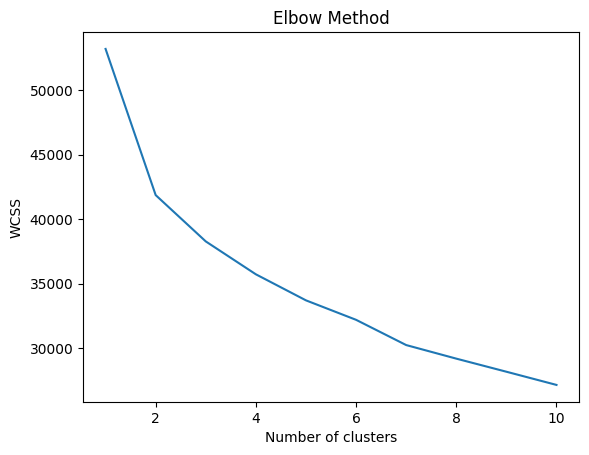

In [69]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [70]:
# Choose the optimal number of clusters based on previous analyses, say k = 4
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df)

KMeans(n_clusters=2, n_init=10, random_state=0)

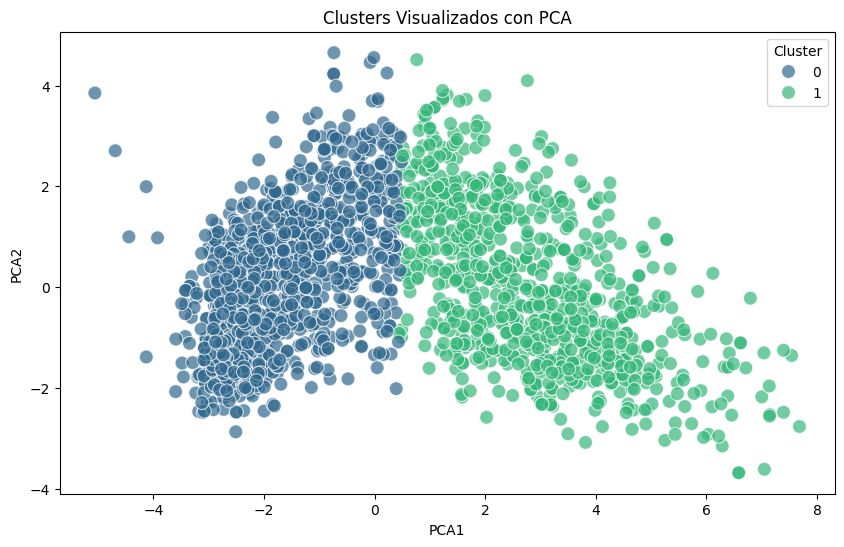

In [71]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df)

# Crear un DataFrame con las componentes principales y las etiquetas de los clusters
df_pca = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='viridis', data=df_pca, s=100, alpha=0.7)
plt.title('Clusters Visualizados con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Accuracy: 0.9530685920577617


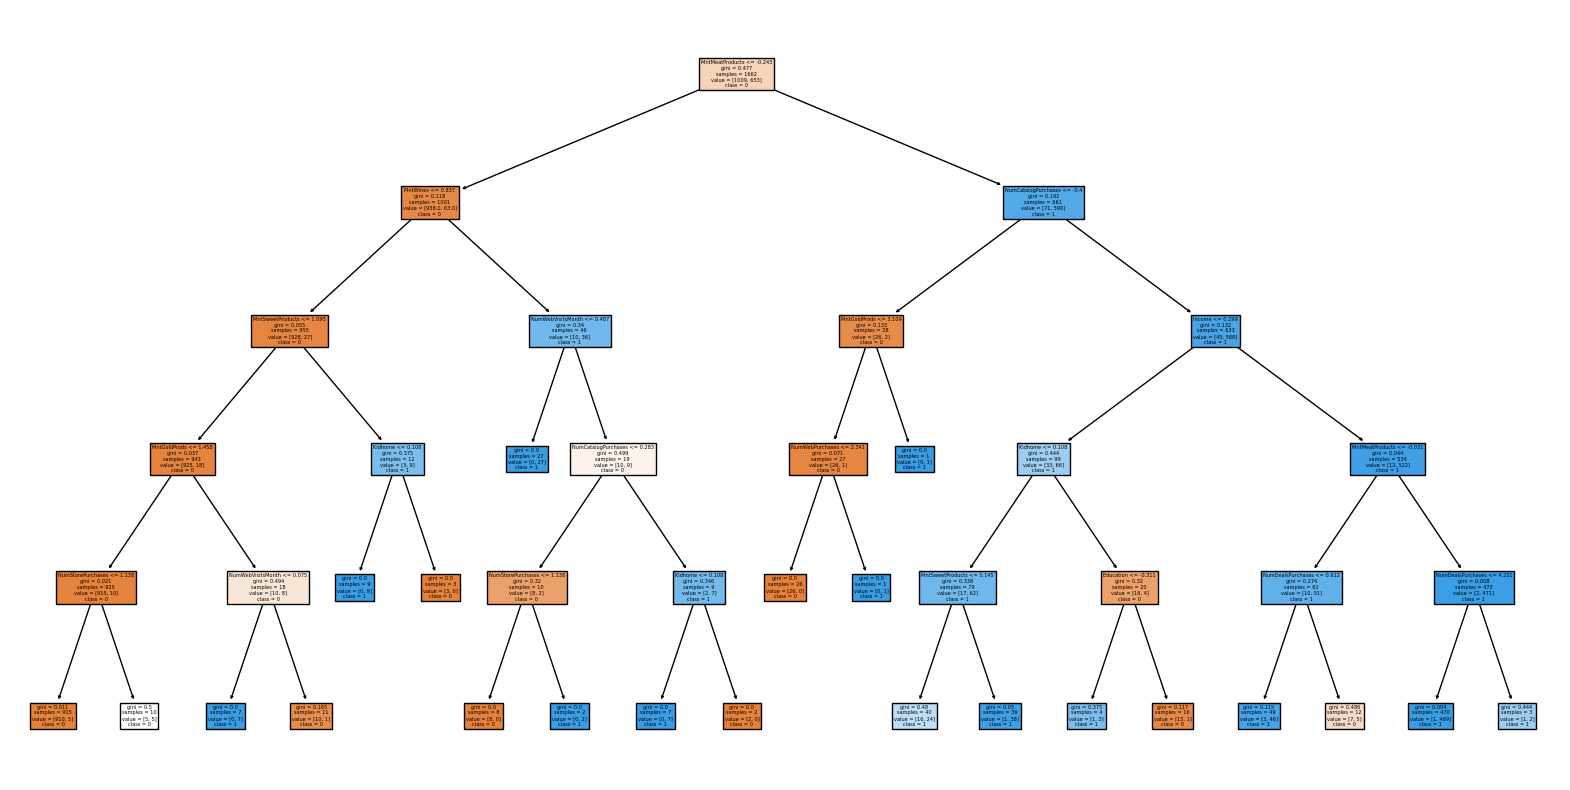

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

X = df
y = pd.DataFrame(kmeans.labels_, columns=['cluster'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
plt.figure(figsize=(20, 10))
tree.plot_tree(dt, filled=True, feature_names=df.columns, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

In [82]:
from dsgd.DSClassifierMultiQ import DSClassifierMultiQ
X_train_ds = X_train.to_numpy()
y_train_ds = y_train.to_numpy()
X_test_ds = X_test.to_numpy()
y_test_ds = y_test.to_numpy()

DSC = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lr=0.0005, 
                                lossfn="MSE", num_workers=1, min_dloss=1e-7, precompute_rules=True)

losses, epoch, dt = DSC.fit(X_train_ds, y_train_ds, add_single_rules=True,
                            single_rules_breaks=5, add_mult_rules=False,
                                column_names=df.columns, print_every_epochs=1, print_final_model=False)
y_pred_ds = DSC.predict(X_test_ds)

Optimization started
Processing epoch	1	1.0000	

/home/dani/Escritorio/Trabajo dirigido/python-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1662, 1, 2])) that is different to the input size (torch.Size([1662, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Processing epoch	200	0.2400	
Training time: 95.38s, epochs: 200

Least training loss reached: 0.240


In [83]:
accuracy = accuracy_score(y_test_ds, y_pred_ds)
print('Accuracy:', accuracy)

Accuracy: 0.6010830324909747


In [84]:
DSC.print_most_important_rules(threshold=0.1)



Most important rules for class 0

	[0.199] R70: NumDealsPurchases > 0.959
			0: 0.198	1: 0.001	Unc: 0.801

	[0.194] R59: MntGoldProds < -0.971
			0: 0.189	1: 0.011	Unc: 0.800

	[0.192] R7: Education = -1.8736971811617769
			0: 0.185	1: 0.015	Unc: 0.800

	[0.192] R21: Teenhome = 0.9090656915177863
			0: 0.185	1: 0.015	Unc: 0.800

	[0.192] R66: -0.961 < NumDealsPurchases < -0.429
			0: 0.183	1: 0.018	Unc: 0.799

	[0.190] R69: 0.426 < NumDealsPurchases < 0.959
			0: 0.181	1: 0.018	Unc: 0.801

	[0.187] R85: -0.418 < NumStorePurchases < 0.014
			0: 0.170	1: 0.036	Unc: 0.794

	[0.183] R30: -0.966 < MntWines < -0.434
			0: 0.169	1: 0.030	Unc: 0.801

	[0.180] R109: Response = -0.4205299744053216
			0: 0.162	1: 0.038	Unc: 0.800

	[0.180] R100: AcceptedCmp5 = 3.5607600797693477
			0: 0.162	1: 0.038	Unc: 0.800

	[0.180] R0: Year_Birth < -1.010
			0: 0.164	1: 0.034	Unc: 0.803

	[0.175] R3: -0.023 < Year_Birth < 0.416
			0: 0.155	1: 0.043	Unc: 0.801

	[0.174] R42: -0.954 < MntMeatProducts < -0.42